## Airbnb seattle 2016 data

The data we are going to explore today is provided by Airbnb. We downloaded an Zip archive that conatins three CSV files. Let us go through the data first 

In [86]:
import pandas as pd
import numpy as np
from scipy import stats
import random
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_listing = pd.read_csv('archive/listings.csv')
df_calendar = pd.read_csv('archive/calendar.csv')
df_reviews = pd.read_csv('archive/reviews.csv')

Let's take a look at the three dataframes 

In [87]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


This df contains written reviews (text) submitted by Airbnb users after staying at one of the listed properties in df_listing
<br><br>

In [88]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


This df shows the days in which each listing was available and occupied through out the year (365 days)
<br><br>

In [89]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

##### This is the main dataframe. It contains information on individual listings and hosts in the city of Seattle. We are going to work with this dataframe to answer the questions below 
<br><br>

## Project questions

Looking at the data, we can think of a couple of interesting questions that could help the stakeholders make better and more informed decisions 
<br><br>
**Question 1)** What percentage of hosts that make 35K$+ a year from their listings on airbnb in seattle ?
<br><br>
**Question 2)** Do properties with a superhost have higher booking rates ?
<br><br>
**Question 3)** Can we predict If a new host has the potenitial to be a superhost from a list of available features ?
<br><br>
We will answer the aforementioned questions. But first, We will asses and clean the data
<br><br>


## Asses and clean

**1- Make sure there are no duplicate rows**

In [90]:
print('Before dropping duplicate rows : df_listing rows = ', df_listing.shape[0])
df_listing = df_listing.drop_duplicates()
print('After dropping duplicate rows : df_listing rows = ', df_listing.shape[0])

Before dropping duplicate rows : df_listing rows =  3818
After dropping duplicate rows : df_listing rows =  3818


<br>**2- Drop columns that are** 

2.1) Redundant : There are other columns that serve the same purpose 

neighbourhood  : We will keep neighbourhood_cleansed<br>
host_total_listings_count and calculated_host_listings_count : We will keep host_listings_count 

2.2) Irrelevant : Will not assist in our analysis or modelling

latitude, longitude, listing_url, scrape_id, last_scraped<br>
picture_url, xl_picture_url, medium_url, thumbnail_url, host_url<br>
host_thumbnail_url, host_picture_url and calendar_last_scraped<br>

2.3) Have all or the vast majority of their values as Null or one value across the whole df

experiences_offered, city, country, country_code,smart_location<br>
state, market, square_feet, license, has_availability<br>
jurisdiction_names and requires_license

Let's drop the columns mentioned above :

In [91]:
df_listing_clean = df_listing.drop(['neighbourhood', 'smart_location', 'host_total_listings_count', 'calculated_host_listings_count', 'latitude', 'longitude', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'xl_picture_url', 'medium_url', 'thumbnail_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped',
                 'experiences_offered', 'city', 'country', 'country_code', 'state', 'market', 'square_feet', 'square_feet', 'license', 'has_availability', 'jurisdiction_names', 'requires_license'], axis=1).copy()
print('Number of columns before dropping = {} and after = {}'.format(df_listing.shape[1], df_listing_clean.shape[1]))

Number of columns before dropping = 92 and after = 64


<br>**3- Make sure All columns have appropriate data types** <br><br>
3.1) Some columns must have a numeric data type (float or int). However, the columns are of object data type. we are going to remove $ and % signs and convert the columns into appropriate data types <br><br>
columns : price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people, host_acceptance_rate and host_response_rate

In [92]:
print(df_listing_clean.iloc[0:3,:].price)
print(df_listing_clean.iloc[0:3,:].security_deposit)
print(df_listing_clean.host_acceptance_rate.unique())

0     $85.00
1    $150.00
2    $975.00
Name: price, dtype: object
0          NaN
1      $100.00
2    $1,000.00
Name: security_deposit, dtype: object
['100%' nan '0%']


We need to write a function that removes the $ and % signs and returns the clean text 

In [93]:
def clean_numeric(num_text, is_money):
    try:
        if is_money:
            num = num_text
            if ',' in num:
                num = num.replace(',', '')

            return num.replace('$', '')

        else:
            return num_text.replace('%', '')

    except:
        # some rows have nan stored as string. We write this exception block to get around it return an actual None value
        return None

In [94]:
df_listing_clean['price'] = df_listing_clean['price'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['weekly_price'] = df_listing_clean['weekly_price'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['monthly_price'] = df_listing_clean['monthly_price'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['security_deposit'] = df_listing_clean['security_deposit'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['cleaning_fee'] = df_listing_clean['cleaning_fee'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['extra_people'] = df_listing_clean['extra_people'].apply(lambda x: clean_numeric(x, True))
df_listing_clean['host_acceptance_rate'] = df_listing_clean['host_acceptance_rate'].apply(lambda x: clean_numeric(x, False))
df_listing_clean['host_response_rate'] = df_listing_clean['host_response_rate'].apply(lambda x: clean_numeric(x, False))
# convert to float data type
df_listing_clean['price'] = df_listing_clean['price'].astype(float)
df_listing_clean['weekly_price'] = df_listing_clean['weekly_price'].astype(float)
df_listing_clean['monthly_price'] = df_listing_clean['monthly_price'].astype(float)
df_listing_clean['security_deposit'] = df_listing_clean['security_deposit'].astype(float)
df_listing_clean['cleaning_fee'] = df_listing_clean['cleaning_fee'].astype(float)
df_listing_clean['extra_people'] = df_listing_clean['extra_people'].astype(float)
df_listing_clean['host_acceptance_rate'] = df_listing_clean['host_acceptance_rate'].astype(float)
df_listing_clean['host_response_rate'] = df_listing_clean['host_response_rate'].astype(float)
print('Check columns\' data types after cleaning\n')
print(df_listing_clean.iloc[:, [14, 15, 35, 36, 37, 38, 39, 41]].dtypes)

Check columns' data types after cleaning

host_response_rate      float64
host_acceptance_rate    float64
price                   float64
weekly_price            float64
monthly_price           float64
security_deposit        float64
cleaning_fee            float64
extra_people            float64
dtype: object


<br>
3.2) Some columns must have a boolean or 0/1 values. However, the columns are stored as string and have only two unique values (t and f). We will turn strings into 0 and 1 integer columns 

columns : host_is_superhost, host_identity_verified, host_has_profile_pic, instant_bookable, require_guest_profile_picture, require_guest_phone_verification and is_location_exact<br><br>
We need to write a function that converts these columns into 0/1 integer columns 

In [95]:
def clean_boolean(bol_text):
    try:
        if bol_text == 't':
            return '1'
        else:
            return '0'

    except:
        # some rows have nan stored as string. We write this exception block to get around it return an actual None value
        return None

In [96]:
df_listing_clean['host_is_superhost'] = df_listing_clean['host_is_superhost'].apply(lambda x: clean_boolean(x))
df_listing_clean['host_identity_verified'] = df_listing_clean['host_identity_verified'].apply(lambda x: clean_boolean(x))
df_listing_clean['host_has_profile_pic'] = df_listing_clean['host_has_profile_pic'].apply(lambda x: clean_boolean(x))
df_listing_clean['instant_bookable'] = df_listing_clean['instant_bookable'].apply(lambda x: clean_boolean(x))
df_listing_clean['require_guest_profile_picture'] = df_listing_clean['require_guest_profile_picture'].apply(lambda x: clean_boolean(x))
df_listing_clean['require_guest_phone_verification'] = df_listing_clean['require_guest_phone_verification'].apply(lambda x: clean_boolean(x))
df_listing_clean['is_location_exact'] = df_listing_clean['is_location_exact'].apply(lambda x: clean_boolean(x))

df_listing_clean['host_is_superhost'] = df_listing_clean['host_is_superhost'].astype(int)
df_listing_clean['host_identity_verified'] = df_listing_clean['host_identity_verified'].astype(int)
df_listing_clean['host_has_profile_pic'] = df_listing_clean['host_has_profile_pic'].astype(int)
df_listing_clean['instant_bookable'] = df_listing_clean['instant_bookable'].astype(int)
df_listing_clean['require_guest_profile_picture'] = df_listing_clean['require_guest_profile_picture'].astype(int)
df_listing_clean['require_guest_phone_verification'] = df_listing_clean['require_guest_phone_verification'].astype(int)
df_listing_clean['is_location_exact'] = df_listing_clean['is_location_exact'].astype(int)
print('Check columns\' data types after cleaning\n')
print(df_listing_clean.iloc[:, [16, 20, 21, 26, 59, 61, 62]].dtypes)

Check columns' data types after cleaning

host_is_superhost                   int64
host_has_profile_pic                int64
host_identity_verified              int64
is_location_exact                   int64
instant_bookable                    int64
require_guest_profile_picture       int64
require_guest_phone_verification    int64
dtype: object


<br>**4- Clean amenities column** <br><br>
each listing can offer multiple amenities. Amenities are stored in a python set in string format. We will go through the each row's set of amenities and remove redundant ones, store updated amenities in a list and return as a string<br><br>Let's write a function to handle this task 

In [97]:
unique_amenities = ['']
def clean_amenities(all_ams):
        amns_list = ['']
        amns = all_ams.replace('{', '').replace('}', '')

        try:
            amns = amns.replace('"', '').split(',')
        except:
            amns = amns.split(',')

        for item in amns:
            if item not in unique_amenities and item not in ['Dog(s)', 'Cat(s)', 'Pets live on this property', 'Other pet(s)', 'Wireless Internet', 'Washer / Dryer', 'Carbon Monoxide Detector']:
                unique_amenities.append(item)
            if item in amns_list:
                continue
            else:
                if item in ['Dog(s)', 'Cat(s)', 'Pets live on this property', 'Other pet(s)']:
                    if 'Pets Allowed' not in amns_list:
                        amns_list.append('Pets Allowed')
                elif item == 'Wireless Internet':
                    if 'Internet' not in amns_list:
                        amns_list.append('Internet')
                elif item == 'Washer / Dryer':
                    if 'Washer' not in amns_list:
                        amns_list.append('Washer')
                    if 'Dryer' not in amns_list:
                        amns_list.append('Dryer')
                elif item == 'Carbon Monoxide Detector':
                    if 'Smoke Detector' not in amns_list:
                        amns_list.append('Smoke Detector')
                elif item == 'Essentials':
                    continue
                else:
                    amns_list.append(item)
        return str(amns_list[1:])

In [98]:
df_listing_clean['amenities'] = df_listing_clean.amenities.apply(lambda x: clean_amenities(x))
unique_amenities[1: ]

['TV',
 'Cable TV',
 'Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Free Parking on Premises',
 'Buzzer/Wireless Intercom',
 'Smoke Detector',
 'First Aid Kit',
 'Safety Card',
 'Fire Extinguisher',
 'Essentials',
 'Pets Allowed',
 'Hot Tub',
 'Indoor Fireplace',
 'Shampoo',
 'Breakfast',
 '24-Hour Check-in',
 'Hangers',
 'Hair Dryer',
 'Iron',
 'Laptop Friendly Workspace',
 'Suitable for Events',
 'Elevator in Building',
 'Lock on Bedroom Door',
 'Wheelchair Accessible',
 'Gym',
 'Pool',
 'Smoking Allowed',
 'Doorman']

<br>**5- Unify units in calendar_updated column** <br><br>
We will make the values consistent across the this column. In order to do that, We will convert months and weeks to days (days = unit) 

In [99]:
df_listing_clean.calendar_updated.unique()

array(['4 weeks ago', 'today', '5 weeks ago', '6 months ago',
       '7 weeks ago', '2 weeks ago', 'yesterday', '5 months ago',
       'a week ago', '5 days ago', '3 days ago', '2 months ago',
       '3 months ago', '4 days ago', '2 days ago', '3 weeks ago',
       '1 week ago', '13 months ago', '6 weeks ago', '8 months ago',
       '12 months ago', '4 months ago', 'never', '6 days ago',
       '10 months ago', '14 months ago', '9 months ago', '7 months ago',
       '30 months ago', '11 months ago', '22 months ago', '16 months ago',
       '15 months ago', '17 months ago'], dtype=object)

In [100]:
def clean_calendar_updated(updated_at):
    time = 0
    if updated_at == 'a week ago':
        time = 7
    elif updated_at == 'today':
        time = 1
    elif updated_at == 'yesterday':
        time = 2
    elif updated_at == 'never':
        time = 0
    elif 'week' in updated_at:
        time = int(re.search(r'\d+', updated_at).group()) * 7
    elif 'month' in updated_at:
        time = int(re.search(r'\d+', updated_at).group()) * 30
    else:
        time = int(re.search(r'\d+', updated_at).group())

    return time

In [101]:
df_listing_clean['calendar_updated_numeric'] = df_listing_clean['calendar_updated'].apply(lambda x: clean_calendar_updated(x))
df_listing_clean['calendar_updated_numeric'] = df_listing_clean['calendar_updated_numeric'].astype(int)

<br>**6- Handle null values and categorical columns (will perform this step later before modelling)** <br><br>


### Let\'s briefly look at descriptive statistics and plot numeric data : 

In [102]:
numeric_df = df_listing_clean.iloc[:, [14, 15, 18, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 63]].copy()
numeric_df.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,3295.000000,3045.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,1866.000000,2788.000000,...,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3191.000000
mean,94.886798,99.967159,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,287.610397,61.710904,...,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.078919
std,11.866705,1.812201,28.628149,1.977599,0.590369,0.883395,1.139480,90.250022,270.222690,48.830341,...,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,1.822348
min,17.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,95.000000,5.000000,...,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.020000
25%,98.000000,100.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,150.000000,25.000000,...,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.695000
50%,100.000000,100.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,250.000000,50.000000,...,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000
75%,100.000000,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,300.000000,83.000000,...,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000
max,100.000000,100.000000,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,5000.000000,300.000000,...,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000


In [103]:
print('\n Percentage of listings that require a secuirity deposit = {}%'.format(round(numeric_df[numeric_df.security_deposit.isnull()==False].shape[0]/numeric_df.shape[0]*100)))
print('\n Percentage of listings that require a cleaning fee = {}% and 75% ask for less than 83$'.format(round(numeric_df[numeric_df.cleaning_fee.isnull()==False].shape[0]/numeric_df.shape[0]*100)))
print('\n Percentage of listings that allow one guest only = {}%'.format(round(numeric_df.query('guests_included == 1.0').shape[0]/numeric_df.shape[0]*100)))
print('\n Percentage of listings that are booked more than 50% of the year = {}%'.format(round(numeric_df.query('availability_365 <= 182').shape[0]/numeric_df.shape[0]*100)))


 Percentage of listings that require a secuirity deposit = 49%

 Percentage of listings that require a cleaning fee = 73% and 75% ask for less than 83$

 Percentage of listings that allow one guest only = 60%

 Percentage of listings that are booked more than 50% of the year = 35%


1) 75% of hosts have a response rate greater than or equal to 98% and an acceptance rate of 100%<br>
2) 50% of hosts have 1 property on airbnb and 75% have 2 or less <br>
3) the majority of listings have 1 bathroom, 1 bedroom and 1 bed <br>
4) 75% of listings are priced below 150 USD <br>
5) The most expensive listing is priced at 1000 USD <br> 
6) half of the listing allow bookings with more than one night <br>
7) 75% of listing get less than 3 reviews per month <br>

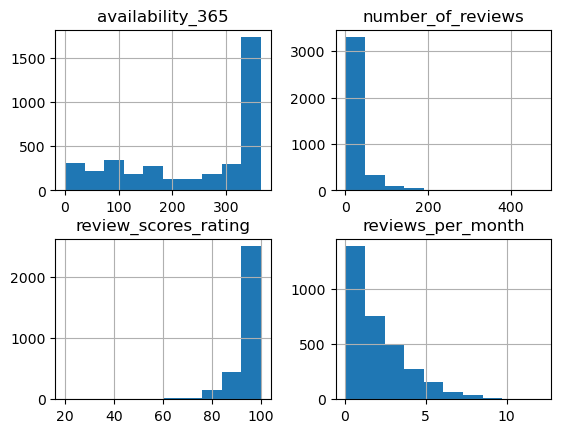

In [104]:
numeric_df.loc[:, ['availability_365', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']].hist();

1) Approximately half of listings are almost available the whole year  
2) Tha vast majority of listings get less than 4 reviews a month 
3) Tha vast majority of listings have a review score rating of 90-100%. There a a few exceptions on the other end of the spectrum 

## We move on to the next step,  answering our questions

**Question 1)** What percentage of hosts that make 35K$+ a year from their listings on airbnb in seattle ?
<br><br>
To answer this question, we first have to calculate the gross revenue of each listing by multiplying the value in the **price** column by (1-availability_365) and store result in a new column called year_revenue

In [105]:
df_listing_clean['year_revenue'] = (365-df_listing_clean['availability_365'])*df_listing_clean['price']
print(' {}% of hosts make 35K$+ from their listings in seattle'.format(round(df_listing_clean.groupby('host_id').year_revenue.sum().reset_index(name='rev').query('rev >= 35000.0').shape[0]/df_listing_clean.host_id.nunique()*100, 2)))
print(' {}% of hosts make 7500$ or less from their listings in seattle'.format(round(df_listing_clean.groupby('host_id').year_revenue.sum().reset_index(name='rev').query('rev <= 7500.0').shape[0]/df_listing_clean.host_id.nunique()*100, 2)))
print(' {}% of hosts make nothing from their listings in seattle'.format(round(df_listing_clean.groupby('host_id').year_revenue.sum().reset_index(name='rev').query('rev == 0.0').shape[0]/df_listing_clean.host_id.nunique()*100, 2)))

 18.28% of hosts make 35K$+ from their listings in seattle
 45.8% of hosts make 7500$ or less from their listings in seattle
 14.94% of hosts make nothing from their listings in seattle


<br>

**Question 2)** Do properties with a superhost have higher booking rates ?
<br><br>
We must test our hypothesis to find out If superhosts have higher booking rates. <br>
H0: superhosts have the same or worse booking rates <br>
H1: superhosts have higher booking rates than regular hosts<br>
<br><br>
First of all, we normalize availability_365 by taking (N) random values and finding their means and repeating this process many times then plotting the means

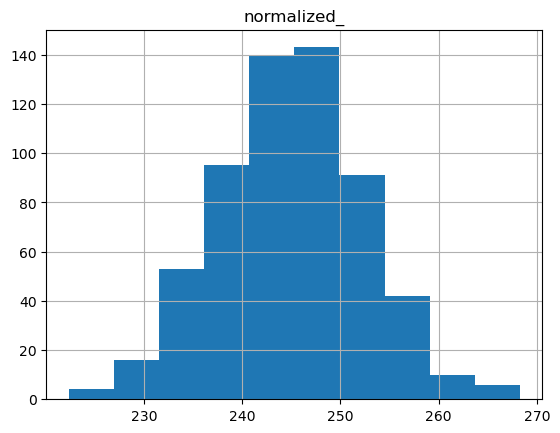

In [106]:
def hyp_test(df):
    normalized = [0]
    for index in range(0, 600):
        iteration = np.array([])
        for j in range(0, 300):
            pos = random.randint(0, df.shape[0]-1)
            iteration = np.insert(iteration, j, df.iloc[pos, 48])
        normalized.append(iteration.mean())

    return pd.DataFrame(data={'normalized_': normalized[1: ]})


normalized_365 = hyp_test(df_listing_clean)
normalized_365.hist();

In [107]:
superhost_mean, host_mean = df_listing_clean.query('host_is_superhost == 1').availability_365.mean(), df_listing_clean.query('host_is_superhost == 0').availability_365.mean()
superhost_var, host_var = df_listing_clean.query('host_is_superhost == 1').availability_365.var(), df_listing_clean.query('host_is_superhost == 0').availability_365.var()
print(' Mean availability_365 : superhosts = {} and hosts = {} days a year'.format(superhost_mean, host_mean))
print(' Variance of availability_365 : superhosts = {} and hosts = {} and ratio = {}'.format(superhost_var, host_var, superhost_var/host_var))

 Mean availability_365 : superhosts = 241.14910025706942 and hosts = 245.7 days a year
 Variance of availability_365 : superhosts = 14724.353544877933 and hosts = 16416.71549851934 and ratio = 0.8969122688521924


<br>We run a two sample T-test to find out if our theory holds up

In [108]:
_, p_value = stats.ttest_ind(a=df_listing_clean.query('host_is_superhost == 1').availability_365, b=df_listing_clean.query('host_is_superhost == 0').availability_365, equal_var=True)
if superhost_mean < host_mean:
    p = p_value/2
else:
    p = 1.0 - p_value/2

print(' Is the p_value {} less than alpha = 0.05 ? {}'.format(p, p < 0.05))
print('\n Conclusion : We reject the alternative hypothesis')
print('\n Superhosts don\'t have higher booking rates than regular hosts')

 Is the p_value 0.18583682847838917 less than alpha = 0.05 ? False

 Conclusion : We reject the alternative hypothesis

 Superhosts don't have higher booking rates than regular hosts


<br>

**Question 3)** Can we predict If a new host has the potenitial to be a superhost from a list of available features ?
<br><br>
We will build a model that classifies hosts (superhost/regular host) based on a number of features
<br>
This model can help us predict wether from a host has the potential to be superhost based on data that's available when the hosts newly list their properties
<br><br>
**What features/columns can we feed this model ?** 
<br>
price - neighborhood - amenities - cleaning fee<br>
secuirity deposit - guests_included - calendar_updated_numeric<br>
extra_people - bed_type - room_type - property_type<br>
cancellation_policy - require_guest_phone_verification<br>
require_guest_profile_picture - instant_bookable
<br><br>
**our target/response = variable host_is_superhost** 

In [109]:
model_df = df_listing_clean.loc[:, ['host_id', 'id', 'host_is_superhost', 'price', 'neighbourhood_cleansed', 'cleaning_fee', 'security_deposit', 'guests_included', 'extra_people', 'calendar_updated_numeric', 'bed_type', 'room_type', 'property_type', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']].copy()

**First, We need to handle null values**
<br><br>
1- our target/response variable host_is_superhost doesn't have any null values<br>
2- price also doesn't have any null values<br>
3- bed_type, room_type, neighbourhood_cleansed, instant_bookable, cancellation_policy, require_guest_profile_picture, calendar_updated_numeric and require_guest_phone_verification all don't have any null values<br>
4- cleaning_fee, security_deposit have null values. We are going to assume that a null value in both of these columns means a fee is not required => fill null with 0

In [110]:
model_df['cleaning_fee'] = model_df['cleaning_fee'].fillna(0)
model_df['security_deposit'] = model_df['security_deposit'].fillna(0)
# property_type has one null value, drop the row
model_df.dropna(subset=['property_type'], inplace=True)
print(model_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3817 entries, 0 to 3817
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_id                           3817 non-null   int64  
 1   id                                3817 non-null   int64  
 2   host_is_superhost                 3817 non-null   int64  
 3   price                             3817 non-null   float64
 4   neighbourhood_cleansed            3817 non-null   object 
 5   cleaning_fee                      3817 non-null   float64
 6   security_deposit                  3817 non-null   float64
 7   guests_included                   3817 non-null   int64  
 8   extra_people                      3817 non-null   float64
 9   calendar_updated_numeric          3817 non-null   int64  
 10  bed_type                          3817 non-null   object 
 11  room_type                         3817 non-null   object 
 12  proper

**Finally, let's handle categorical variables**
<br><br>
We will use the get_dummies function to create dummy columns for each unique value in the following columns <br>
neighbourhood_cleansed, bed_type, room_type, property_type and cancellation_policy

In [111]:
model_df = pd.get_dummies(model_df, columns=['neighbourhood_cleansed', 'bed_type', 'room_type', 'property_type', 'cancellation_policy'], dtype=int, prefix=['neighbourhood', 'bed', 'room', 'property', 'cancel'])
model_df.columns

Index(['host_id', 'id', 'host_is_superhost', 'price', 'cleaning_fee',
       'security_deposit', 'guests_included', 'extra_people',
       'calendar_updated_numeric', 'instant_bookable',
       ...
       'property_House', 'property_Loft', 'property_Other', 'property_Tent',
       'property_Townhouse', 'property_Treehouse', 'property_Yurt',
       'cancel_flexible', 'cancel_moderate', 'cancel_strict'],
      dtype='object', length=126)

Also, We need to create dummy columns for each unique amenity. However, it is a bit tricky as one listing can have multiple values<br><br>
1- We will create numpy zeros matrix of size 3818 X number_unique_amenities + 1 <br>
2- go through the dataframe row by row (for loop) and check the amenities column <br>
3- create a nested loop for each item in the unique_amenities list <br>
4- if item is in row's amenities, then set matrix[current_index_first_loop][current_index_nested_loop] = 1 <br>
5- At the end of each iteration of the first loop, set matrix[current_index_first_loop][-1] = listing_id <br>

In [112]:
def dummies_amenities(df):
    matrix = []
    for i in range(0, 3818):
        matrix.append(np.zeros(len(unique_amenities) + 1).tolist())

    for index_x, row in df.iterrows():
        for index_j in range(0, len(unique_amenities)):
            if unique_amenities[index_j] in row['amenities']:
                matrix[index_x][index_j] = 1
        matrix[index_x][-1] = row['id']

    unique_amenities.append('id')
    return pd.DataFrame(data=matrix, columns=unique_amenities).astype(int).copy()

In [113]:
unique_amenities = unique_amenities[1:]
model_df = model_df.merge(dummies_amenities(df_listing_clean), on='id', how='inner')
model_df.dtypes

host_id                    int64
id                         int64
host_is_superhost          int64
price                    float64
cleaning_fee             float64
                          ...   
Wheelchair Accessible      int64
Gym                        int64
Pool                       int64
Smoking Allowed            int64
Doorman                    int64
Length: 160, dtype: object

<br><br>
our target/response variable host_is_superhost is a binary variable<br>
which means where are going to select a classification algorithm for our model<br>
**SVM** (support vector machine) is one of the most popular and widely used algorithms for classifications<br><br>
Let's split our data into trainging and testing groups 

In [116]:
X_train, X_test, y_train, y_test = train_test_split(model_df.iloc[:, 3:], model_df.iloc[:, 2], test_size=0.33, random_state=42)

<br>
Then, create the model and fit the model to the training data 

In [117]:
superhostModel = svm.SVC()
superhostModel.fit(X_train, y_train)

SVC()

Finally, Let's test the accuracy of our model

In [119]:
predicted = superhostModel.predict(X_test)
print('Accuracy (out of 1) = {}'.format(accuracy_score(y_test, predicted)))

Accuracy (out of 1) = 0.7841269841269841


An accuracy score of 0.78/1 is really good. It is safe to say that our model will do a good job predicting our target variable 